In [3]:
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import pandas as pd

In [4]:

histAMOCI = '[HIST AMOCI PATH]'

# file paths
sst_hist = '[regridded TOS HIST]'


## Loading and viewing the SST data. Setting lat and lon.

histSSTData = xr.open_dataset(sst_hist)

histSSTData = histSSTData.tos

lat = histSSTData.lat
lon = histSSTData.lon

## Here I am loading and adjusting the AMOC dataset.

hist_amoc_index = (xr.open_dataset(histAMOCI))
divide_amoc = hist_amoc_index.msftmz
hist_amoc_index = divide_amoc/1e9

# take anomaly of the AMOC

hist_amoc_index_anomaly = hist_amoc_index - hist_amoc_index.mean(dim="year")

# Here I generate the p, r2, and slope values by running a linear regression of all latitude and longitudes together.
# I use 180,360 because that's the size of the lat and lon (lat = 180, lon = 360)

import scipy.stats as sp

slope = np.zeros((10,180,360))
r2 = np.zeros((10,180,360))
pval = np.zeros((10,180,360))

for m in range(0,10):
    hist_amoc_index_anomaly_analyze = hist_amoc_index_anomaly[m,:]
    histSST_analyze = histSSTData[m]
    print("Realization # =", m+1)
    for i in range(len(lat)):
        for j in range(len(lon)):
            a, b, r, p, err = sp.stats.linregress(hist_amoc_index_anomaly_analyze, histSST_analyze[:,i,j])
            r2[m,i,j] = r**2
            slope[m,i,j] = a
            pval[m,i,j] = p

Realization # = 1


/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_10411/3137713350.py:65: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  a, b, r, p, err = sp.stats.linregress(hist_amoc_index_anomaly_analyze, histSST_analyze[:,i,j])


Realization # = 2
Realization # = 3
Realization # = 4
Realization # = 5
Realization # = 6
Realization # = 7
Realization # = 8
Realization # = 9
Realization # = 10


In [5]:
r2 = np.mean(r2, axis=0)
slope = np.mean(slope, axis=0)
pval = np.mean(pval, axis=0)

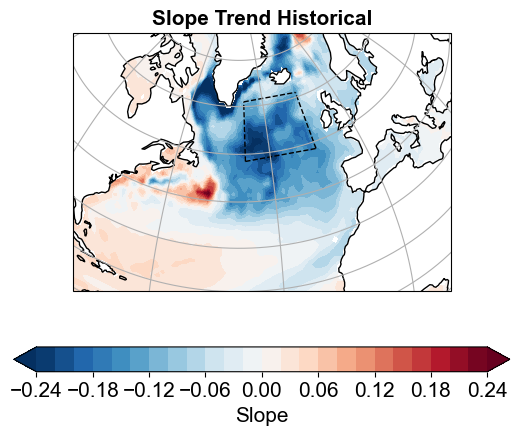

In [7]:

def sample_data():

    crs = ccrs.RotatedPole(pole_longitude=180)
    
    x = lon
    y = lat

    return x, y, crs


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=50,central_longitude=320))

    ax.set_global()
    ax.gridlines()

    x, y, vector_crs = sample_data()
    
    clevs = np.arange(-.24, .26, 0.02)

    cb = ax.contourf(x,y,-slope, clevs ,cmap='RdBu_r',extend='both', transform=vector_crs)  

    ax.set_title('Slope Trend Historical',loc='center',fontdict={'weight': 'bold', 'size': 15})

    plt.plot([-38,-38],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-15,-15],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[48.5,48.5],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[61,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.rcParams.update({'font.family':'sans-serif'})
    plt.rcParams.update({'font.sans-serif':'Arial'})
    plt.minorticks_on()
    
    cbar = fig.colorbar(cb,ax=ax,orientation='horizontal')
    cbar.set_label('Slope',fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    ax.add_feature(cfeature.COASTLINE,lw=1,zorder=1.2)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='white')
    ax.set_extent((-80,15,20,69), crs = ccrs.PlateCarree())

    fig_name = 'Slope Trend Historical'
    fig_dir = '[EXPORT PATH]'
    plt.savefig(fig_dir + fig_name, dpi=600, facecolor='white', transparent=False) 
    plt.show()

if __name__ == '__main__':
    main()

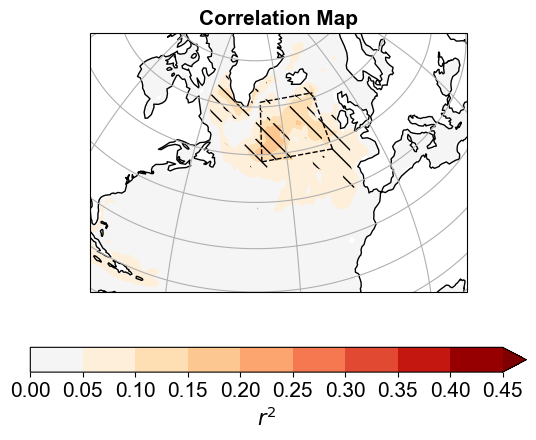

In [8]:

# r2 correlation map

def sample_data():

    crs = ccrs.RotatedPole(pole_longitude=180)

    x = lon
    y = lat

    return x, y, crs


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=50,central_longitude=320))


    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='white')

    ax.set_global()
    ax.gridlines()

    x, y, vector_crs = sample_data()

    clevs = np.arange(0, 0.5, 0.05)
    #clevs = np.arange(-2.4, 2.6, 0.2)

    cmap_min = plt.get_cmap('OrRd')
    cmap_min.set_under('whitesmoke')
    cb = ax.contourf(x,y,r2,clevs,cmap=cmap_min, extend='max', transform=vector_crs, vmin=0.05)
    
    # Add hatches
    ax.contourf(x, y, pval, levels=[0, 0.05], hatches=['\\\\'], colors='none', transform=vector_crs)
    
    ax.add_feature(cfeature.COASTLINE,lw=1,zorder=1.2)
    ax.set_extent((-80,15,20,69), crs = ccrs.PlateCarree())


    ax.set_title('Correlation Map',loc='center',fontdict={'weight': 'bold', 'size': 15})

    plt.plot([-38,-38],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-15,-15],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[48.5,48.5],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[61,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.rcParams.update({'font.family':'sans-serif'})
    plt.rcParams.update({'font.sans-serif':'Arial'})
    
    cbar = fig.colorbar(cb,ax=ax,orientation='horizontal')
    cbar.set_label('$r^2$',fontsize=15)
    cbar.ax.tick_params(labelsize=15)


    fig_name = 'r2 correlation map'
    fig_dir = '[EXPORT PATH]'
    plt.savefig(fig_dir + fig_name, dpi=600, facecolor='white', transparent=False) 
    plt.show()



if __name__ == '__main__':
    main()

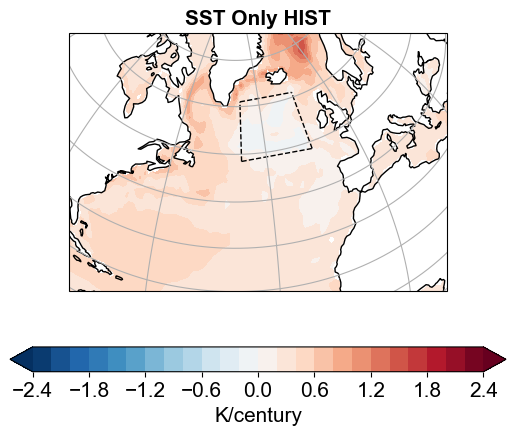

In [10]:
#SST only

def sample_data():

    crs = ccrs.RotatedPole(pole_longitude=180)
    
    x = lon
    y = lat

    return x, y, crs

def delta(var):
    return var.polyfit(dim='year', deg=1).polyfit_coefficients[0]

def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=50,central_longitude=320))

    ax.set_global()
    ax.gridlines()

    x, y, vector_crs = sample_data()
    
    clevs = np.arange(-2.4, 2.6, 0.2)

    dtos_val = [delta(histSSTData[i]) for i in range(10)]
    dtos = np.mean(dtos_val, axis=0)
    dtos=dtos*100
    cb = ax.contourf(x,y,dtos, clevs ,cmap='RdBu_r',extend='both', transform=vector_crs)

    ax.set_title('SST Only HIST',loc='center',fontdict={'weight': 'bold', 'size': 15})

    plt.plot([-38,-38],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-15,-15],[48.5,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[48.5,48.5],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.plot([-38,-15],[61,61],linewidth=1, transform=ccrs.PlateCarree(), color='k', linestyle = 'dashed')
    plt.rcParams.update({'font.family':'sans-serif'})
    plt.rcParams.update({'font.sans-serif':'Arial'})
    plt.minorticks_on()
    
    cbar = fig.colorbar(cb,ax=ax,orientation='horizontal')
    cbar.set_label('K/century',fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    ax.add_feature(cfeature.COASTLINE,lw=1,zorder=1.2)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='white')
    ax.set_extent((-80,15,20,69), crs = ccrs.PlateCarree())

    fig_name = 'SST Only HIST'
    fig_dir = '[EXPORT PATH]'
    plt.savefig(fig_dir + fig_name, dpi=600, facecolor='white', transparent=False) 
    plt.show()

if __name__ == '__main__':
    main()